In [2]:
import sys
import os

sys.path.append(os.path.abspath(".."))

import gymnasium as gym
import my_envs 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6) # Tamanho padrão das imagens

# 1. Caracterização do Ambiente e Definição do MDP

Neste projeto, abordamos o problema de controlo contínuo **BipedalWalker-v3** num contexto de **Aprendizagem por Reforço (RL)**. O objetivo é treinar um agente bípede para caminhar num terreno irregular.

Além de resolver o ambiente padrão, propomos uma variante desafiante: **InjuredBipedalWalker**. Nesta variante, simulamos uma falha mecânica numa das pernas para estudar a capacidade de adaptação e robustez de diferentes algoritmos de RL.

## 1.1. Espaço de Observação ($\mathcal{S}$)

O ambiente é **Fully Observable**. O agente recebe um vetor contínuo de 24 valores ($\mathcal{S} \subset \mathbb{R}^{24}$) a cada timestep, que descreve a propriocepção (ângulos, velocidades) e a perceção do terreno (LIDAR).

A tabela abaixo detalha cada componente deste vetor:

In [3]:
# Criar ambiente temporário para inspeção
env = gym.make("BipedalWalker-v3")

# Nomes das observações baseados na documentação oficial
obs_names = [
    "Hull Angle", "Hull Angular Velocity", "Vel X", "Vel Y",
    "Hip 1 Angle", "Hip 1 Speed", "Knee 1 Angle", "Knee 1 Speed", "Leg 1 Contact",
    "Hip 2 Angle", "Hip 2 Speed", "Knee 2 Angle", "Knee 2 Speed", "Leg 2 Contact",
    "Lidar 1", "Lidar 2", "Lidar 3", "Lidar 4", "Lidar 5",
    "Lidar 6", "Lidar 7", "Lidar 8", "Lidar 9", "Lidar 10"
]

low = env.observation_space.low
high = env.observation_space.high
# Construir DataFrame
df_obs = pd.DataFrame({
    "Índice": range(24),
    "Descrição": obs_names,
    "Min (Teórico)": low, 
    "Max (Teórico)": high
})

# Mostrar tabela formatada
display(df_obs)

,Índice,Descrição,Min (Teórico),Max (Teórico)
0,0,Hull Angle,-3.141593,3.141593
1,1,Hull Angular Velocity,-5.000000,5.000000
2,2,Vel X,-5.000000,5.000000
3,3,Vel Y,-5.000000,5.000000
4,4,Hip 1 Angle,-3.141593,3.141593
5,5,Hip 1 Speed,-5.000000,5.000000
6,6,Knee 1 Angle,-3.141593,3.141593
7,7,Knee 1 Speed,-5.000000,5.000000
8,8,Leg 1 Contact,-0.000000,5.000000
9,9,Hip 2 Angle,-3.141593,3.141593


## 1.2. Espaço de Ações ($\mathcal{A}$)

O espaço de ações é contínuo e quadridimensional ($\mathcal{A} = [-1, 1]^4$). O agente controla diretamente o **torque** aplicado aos motores das ancas e joelhos.

* **Intervalo:** $[-1, 1]$ (Normalizado).
* **Significado:** $-1$ aplica torque máximo numa direção, $1$ na oposta, e $0$ desliga o motor.

In [5]:
# Nomes das Ações
action_names = [
    "Hip 1 (Torque)",  # Anca Esquerda
    "Knee 1 (Torque)", # Joelho Esquerdo
    "Hip 2 (Torque)",  # Anca Direita
    "Knee 2 (Torque)"  # Joelho Direito
]

# Limites reais do ambiente
low = env.action_space.low
high = env.action_space.high

df_actions = pd.DataFrame({
    "Índice": range(4),
    "Ação (Motor)": action_names,
    "Min": low,
    "Max": high
})

display(df_actions)

,Índice,Ação (Motor),Min,Max
0,0,Hip 1 (Torque),-1.0,1.0
1,1,Knee 1 (Torque),-1.0,1.0
2,2,Hip 2 (Torque),-1.0,1.0
3,3,Knee 2 (Torque),-1.0,1.0


## 1.3. Visualização: O Ambiente "Saudável"

O ambiente original (`BipedalWalker-v3`) apresenta um robô simétrico com força total em ambas as pernas. Abaixo apresentamos o estado inicial do robô.

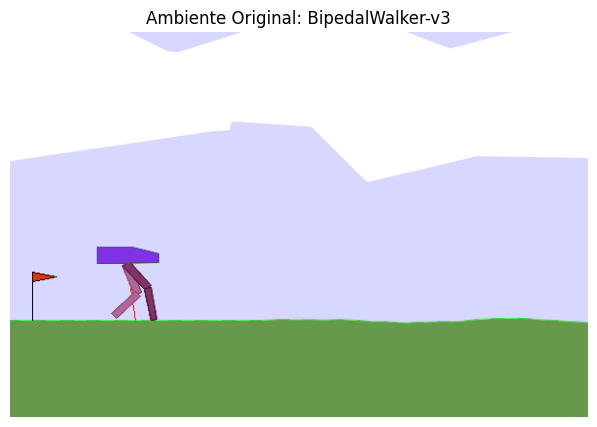

In [6]:
# Função auxiliar para capturar frame
def capture_frame(env_id):
    env = gym.make(env_id, render_mode="rgb_array")
    env.reset()
    # Dar alguns passos aleatórios para o boneco se mexer um pouco
    for _ in range(10):
        env.step(env.action_space.sample())
    frame = env.render()
    env.close()
    return frame

# Mostrar
plt.figure(figsize=(8, 5))
plt.imshow(capture_frame("BipedalWalker-v3"))
plt.title("Ambiente Original: BipedalWalker-v3")
plt.axis("off")
plt.show()

## 1.4. Proposta de Modificação: "Injured Walker"

Para testar a robustez dos algoritmos, desenvolvemos o ambiente **`InjuredBipedalWalker-v0`**.

### A Falha Mecânica
Simulamos uma perda de potência de **70% na perna direita**. Isto é implementado intercetando o vetor de ação antes de este chegar ao motor de física:

$$a'_{direita} = a_{direita} \times 0.3$$

### Código da Modificação
A classe personalizada herda do ambiente original e sobrescreve o método `step`:

```python
class InjuredBipedalWalker(BipedalWalker):
    def step(self, action):
        # Índices 2 e 3 correspondem à Anca e Joelho da perna direita
        action[2] *= 0.3  # Redução de força
        action[3] *= 0.3
        return super().step(action)

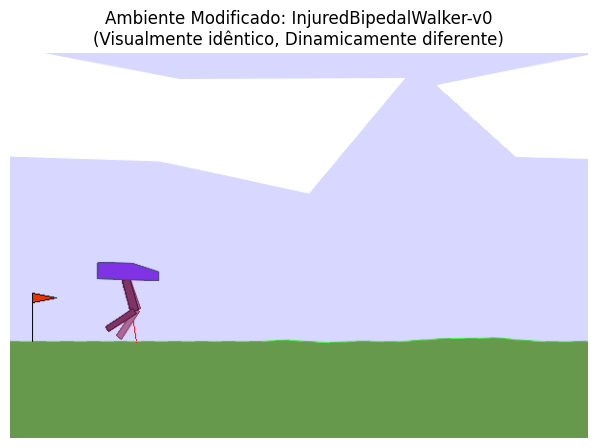

✅ Ambiente 'InjuredBipedalWalker-v0' carregado com sucesso!


In [7]:
# Validar se o ambiente carrega corretamente
try:
    frame_injured = capture_frame("InjuredBipedalWalker-v0")
    
    plt.figure(figsize=(8, 5))
    plt.imshow(frame_injured)
    plt.title("Ambiente Modificado: InjuredBipedalWalker-v0\n(Visualmente idêntico, Dinamicamente diferente)")
    plt.axis("off")
    plt.show()
    
    print("✅ Ambiente 'InjuredBipedalWalker-v0' carregado com sucesso!")
    
except Exception as e:
    print(f"❌ Erro ao carregar ambiente modificado: {e}")
    print("Verifica se o ficheiro 'my_envs/injured_bipedal.py' existe e está correto.")

## 1.5. Conclusões desta fase e ligação ao Notebook 2

Com esta exploração inicial ficam definidos dois cenários experimentais:

- **Ambiente de referência (`BipedalWalker-v3`)**: serve para comparar eficiência de aprendizagem e estabilidade em condições “normais”.
- **Ambiente problemático (`InjuredBipedalWalker-v0`)**: introduz uma falha mecânica específica, preservando observações e recompensa, para avaliar **robustez** e **capacidade de adaptação**.

Este enquadramento permite, no Notebook 2, selecionar um algoritmo e configurar um **baseline forte e consistente** no ambiente saudável, para depois comparar o impacto da degradação no ambiente problemático de forma controlada.
